In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle



dist_pickle=pickle.load(open('./camera_cal/cal_dist_pickle.p','rb'))

mtx = dist_pickle['mtx']
dist = dist_pickle['dist']
print(mtx)




[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Take the absolute value of the derivative or gradient
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    binary_output = np.zeros_like(scaled_sobel)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, # 不同处
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0, 255),vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv= cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    v_binary = np.zeros_like(s_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output=np.zeros_like(s_channel)
    output[(s_binary==1)&(v_binary==1)]=1
    return output


def window_mask(width,height,img_ref,center,level):
    output=np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width)):min(int(center+width),img_ref.shape[1])]=1
    return output






In [37]:
class Tracker1 :
    def __init__(self, Mywindow_width=50, Mywindow_height=80, Mymargin=25, My_ym=10/72, My_xm=4/384, Mysmooth_factor=15):
        self.recent_centers=[]
        self.window_width=Mywindow_width  #宽度
        self.window_height=Mywindow_height #高度
        self.margin=Mymargin  #像素距离
        self.ym_per_pix=My_ym  #垂直方向的像素
        self.xm_per_pix=My_xm  #水平方向的像素
        self.smooth_factor=Mysmooth_factor
        self.curvatures = []


    def find_window_centroids(self,warped):  #车道线位置 左右中心线
        window_width=self.window_width
        window_height=self.window_height
        margin=self.margin
        window_centroids=[]
        window=np.ones(window_width) # 用于卷积的窗口模版
       
     
            #左右中心线的始位置  四分之一处开始
        l_sum=np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)],axis=0)
        l_center=np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum=np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):],axis=0)
        r_center=np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer

        window_centroids.append((l_center,r_center))  # 第一层
        #print('l_sum',int(3*warped.shape[0]/4))
        #print(warped.shape[0])
        #print(warped.shape[1])
        
        #print('r_sum',int(warped.shape[1]/2))
        for level in range(1,(int)(warped.shape[0]/window_height)):
            image_layer=np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:],axis=0)
            conv_signal=np.convolve(window,image_layer)
             # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset=window_width/2
            l_min_index=int(max(l_center+offset-margin,0))
            l_max_index=int(min(l_center+offset+margin,warped.shape[1]))
            l_center=np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            # Find the best right centroid by using past right center as a reference
            r_min_index=int(max(r_center+offset-margin,0))
            r_max_index=int(min(r_center+offset+margin,warped.shape[1]))
            r_center=np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
              # Update window_centroids

            window_centroids.append((l_center,r_center))

        self.recent_centers.append(window_centroids)
        #返回的是中心线的平均值
        return np.average(self.recent_centers[-self.smooth_factor:],axis=0)



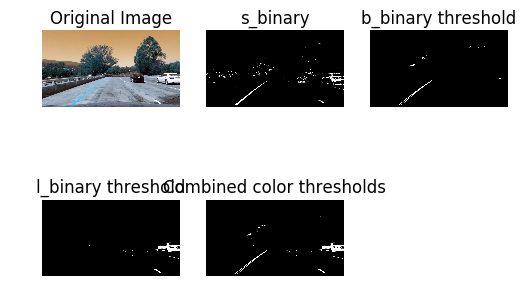

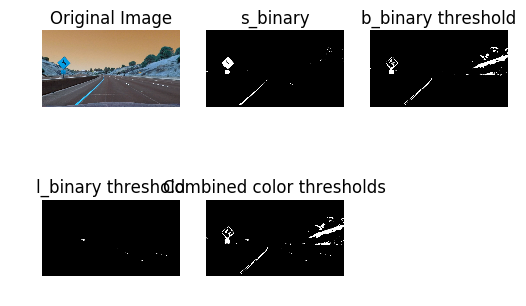

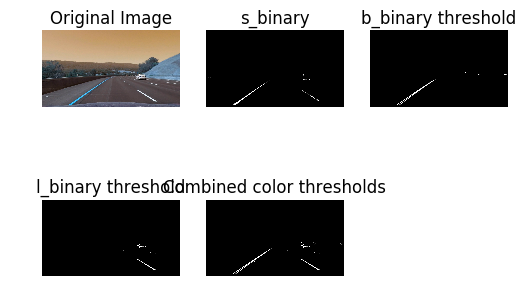

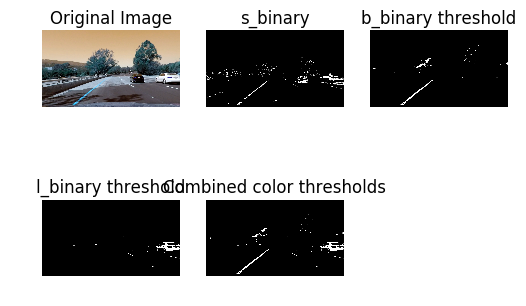

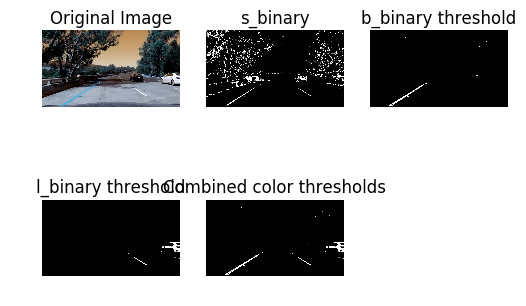

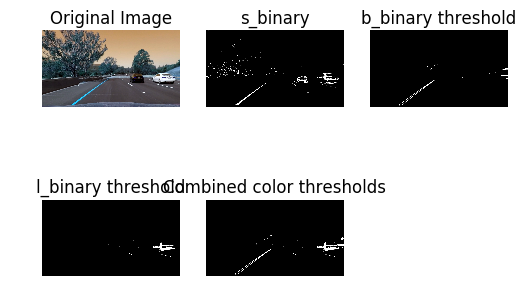

In [5]:
images=glob.glob('./test_images/test*.jpg')
#images=glob.glob('./test_images/test2.jpg')

for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img=cv2.undistort(img,mtx,dist,None,mtx)
    ####L channel from LUV for white lines and the b channel from Lab for yellow lines.
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    plt.subplot(2, 3, 1)
    plt.title('Original Image', fontsize=12)
    plt.imshow(img)
    plt.axis('off') 

    plt.subplot(2, 3, 2)
    plt.title('s_binary', fontsize=12)
    plt.imshow(s_binary, cmap='gray')
    plt.axis('off') 

    plt.subplot(2, 3, 3)
    plt.title('b_binary threshold', fontsize=12)
    plt.imshow(b_binary, cmap='gray')
    plt.axis('off') 

    plt.subplot(2, 3, 4)
    plt.title('l_binary threshold', fontsize=12)
    plt.imshow(l_binary, cmap='gray')
    plt.axis('off') 

    plt.subplot(2, 3, 5)
    plt.title('Combined color thresholds', fontsize=12)
    plt.imshow(combined_binary, cmap='gray')
    plt.axis('off')
    #plt.savefig('./output_images/binary_image_new'+str(idx)+'.png',dpi=100)
    plt.show()








## perspective transform


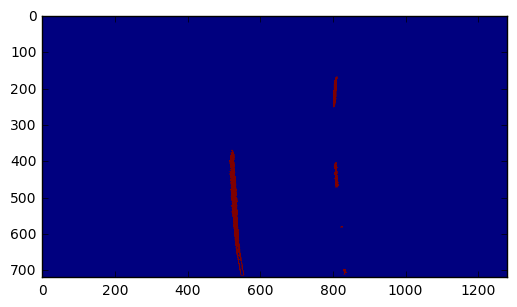

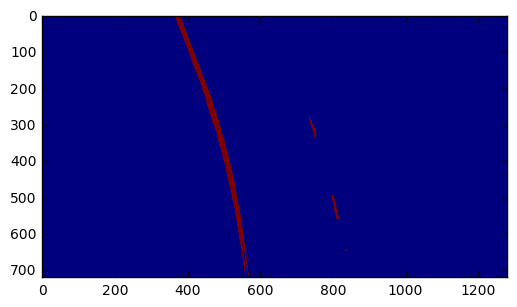

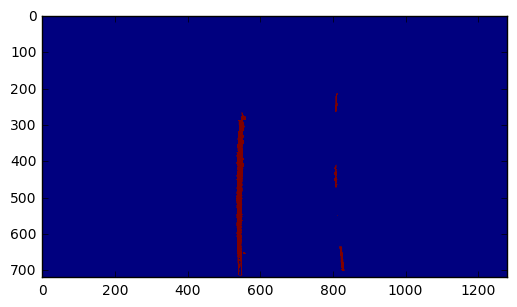

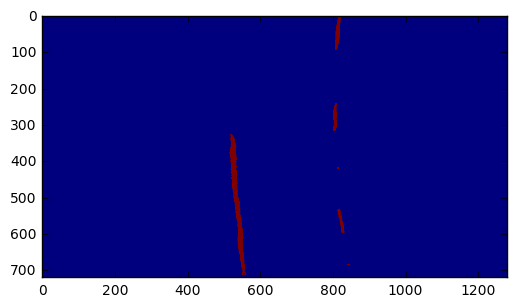

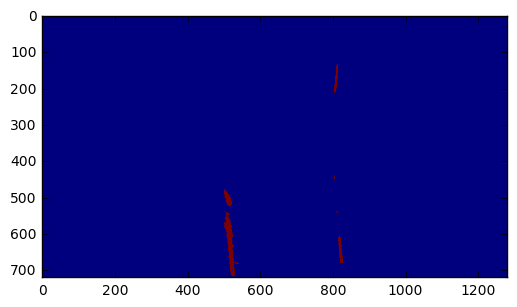

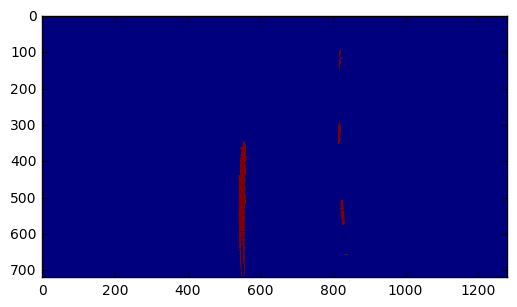

In [12]:
def binary_transf(img):
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary



def region_of_interest(img, vertices):
        mask = np.zeros_like(img)
        ignore_mask_color = 255

        # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_edges = cv2.bitwise_and(img, mask)
        return masked_edges

for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img=cv2.undistort(img,mtx,dist,None,mtx)
    preprocessImage=binary_transf(img)
    
    
    img_size=(img.shape[1],img.shape[0])
    col=img.shape[1]
    row=img.shape[0]
    offset = 300
    src = np.float32([[[col * 0.05, row],                   # bottom-left
                   [col * 0.95, row],                   # bottom-right
                   [col * 0.60, row * 0.62],            # top-right
                   [col * 0.43, row * 0.62]]])          # top-left

    dst = np.float32([[col*0.15 + offset, row],             # bottom left
                  [col*0.90 - offset, row],             # bottom right
                     [col- offset, 0],               # top right
                  [offset, 0]])              # top left
    ss=src.astype(int)
    binary_roi = region_of_interest(preprocessImage, ss)
    #plt.imshow(binary_roi)
    #plt.show()
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #warped = cv2.warpPerspective(preprocessImage, M, img_size)
    warped = cv2.warpPerspective(binary_roi, M, img_size)
    plt.imshow(warped)
    plt.show()



## Lane Fitting  There are some error that  sliding window doesn't find the appropriate points? 

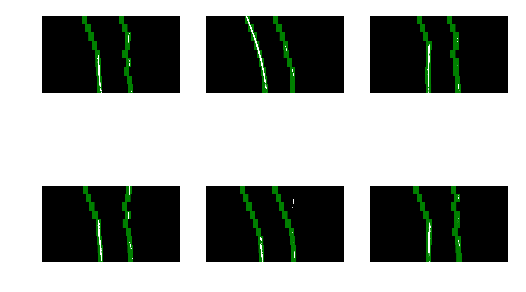

In [38]:

def birdeye_view(img):
    img_size=(img.shape[1],img.shape[0])
    col=img.shape[1]
    row=img.shape[0]
    offset = 300
    src = np.float32([[[col * 0.05, row],                   # bottom-left
                   [col * 0.95, row],                   # bottom-right
                   [col * 0.60, row * 0.62],            # top-right
                   [col * 0.43, row * 0.62]]])          # top-left

    dst = np.float32([[col*0.15 + offset, row],             # bottom left
                  [col*0.90 - offset, row],             # bottom right
                     [col- offset, 0],               # top right
                  [offset, 0]])              # top left
    ss=src.astype(int)
    binary_roi = region_of_interest(preprocessImage, ss)
    #plt.imshow(binary_roi)
    #plt.show()
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #warped = cv2.warpPerspective(preprocessImage, M, img_size)
    warped = cv2.warpPerspective(binary_roi, M, img_size)
    return warped

for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img=cv2.undistort(img,mtx,dist,None,mtx)
    preprocessImage=binary_transf(img)
    warped=birdeye_view(preprocessImage)
    window_width=25   #25  
    window_height=80
    curve_centers=Tracker1(Mywindow_width=window_width,Mywindow_height=window_height,Mymargin=30,My_ym=30/720,My_xm=3.7/700,Mysmooth_factor=15)
     
    window_centroids=curve_centers.find_window_centroids(warped)
    
    
    l_points=np.zeros_like(warped)
    r_points=np.zeros_like(warped)
 
    leftx=[]
    rightx=[]
   
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_mask=window_mask(window_width,window_height,warped,window_centroids[level][0],level)  
        r_mask=window_mask(window_width,window_height,warped,window_centroids[level][1],level)  
 
        l_points[(l_points==255)|((l_mask==1))]=255
        r_points[(r_points==255)|((r_mask==1))]=255
        # Draw the results
 
    template=np.array(r_points+l_points,np.uint8)
    zero_channel=np.zeros_like(template)
    template=np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    #warpage=np.array(cv2.merge((warped,warped,warped)),np.uint8)
    warpage=np.array(cv2.merge((warped*255,warped*255,warped*255)),np.uint8)
    
    #result=cv2.addWeighted(warpage,1,template,0.2,0.0)
    result=cv2.addWeighted(warpage,1,template,0.5,0.0)
   
    plt.subplot(2,3,idx+1)
    plt.imshow(result)
    plt.axis('off')
   
    #plt.title('window fitting results')

plt.show()




/Users/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


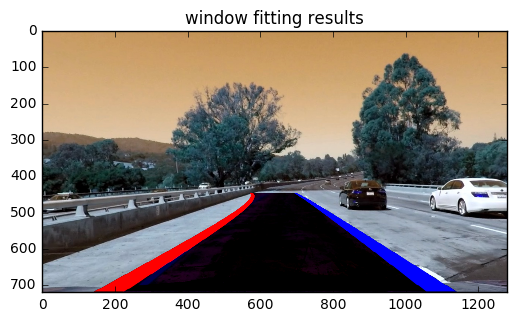

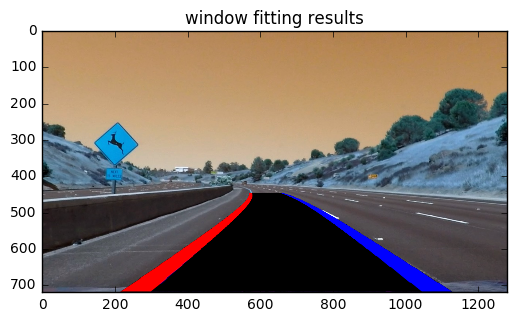

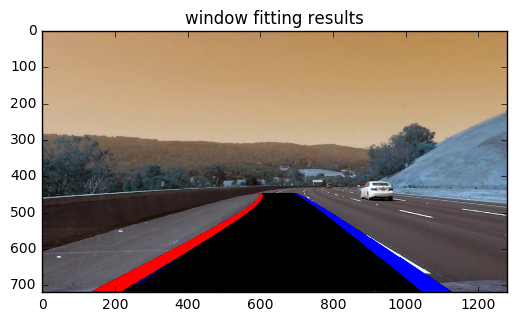

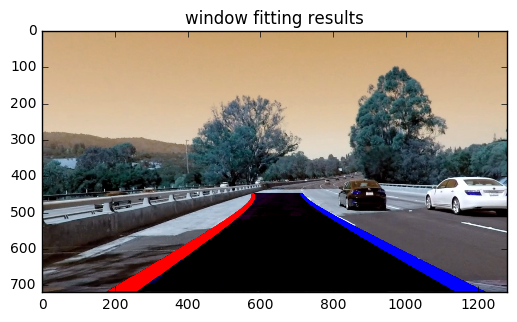

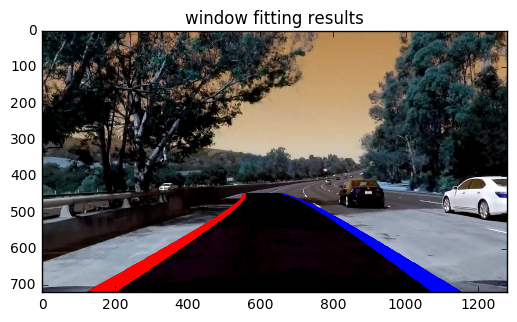

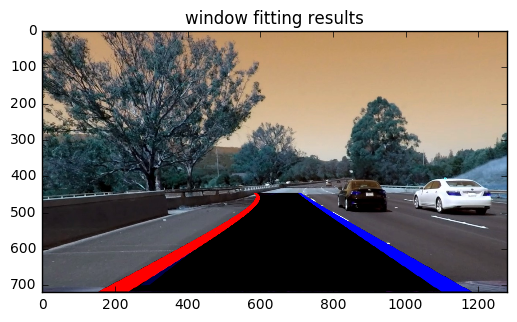

In [41]:
for idx,fname in enumerate(images):
    img=cv2.imread(fname)
    img=cv2.undistort(img,mtx,dist,None,mtx)
    preprocessImage=binary_transf(img)
    warped=birdeye_view(preprocessImage)
    window_width=25   #25  
    window_height=80
    curve_centers=Tracker1(Mywindow_width=window_width,Mywindow_height=window_height,Mymargin=30,My_ym=30/720,My_xm=3.7/700,Mysmooth_factor=15)
     
    window_centroids=curve_centers.find_window_centroids(warped)
    
    
    l_points=np.zeros_like(warped)
    r_points=np.zeros_like(warped)
 
    leftx=[]
    rightx=[]
   
    for level in range(0,len(window_centroids)):
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        l_mask=window_mask(window_width,window_height,warped,window_centroids[level][0],level)  
        r_mask=window_mask(window_width,window_height,warped,window_centroids[level][1],level)  
 
        l_points[(l_points==255)|((l_mask==1))]=255
        r_points[(r_points==255)|((r_mask==1))]=255
        # Draw the results
 
    template=np.array(r_points+l_points,np.uint8)
    zero_channel=np.zeros_like(template)
    template=np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    #warpage=np.array(cv2.merge((warped,warped,warped)),np.uint8)
    warpage=np.array(cv2.merge((warped*255,warped*255,warped*255)),np.uint8)
    
    #result=cv2.addWeighted(warpage,1,template,0.2,0.0)
    result=cv2.addWeighted(warpage,1,template,0.5,0.0)



    yvals=range(0,warped.shape[0])

    
    res_yvals=np.arange(warped.shape[0]-(window_height/2),0,-window_height)

    left_fit=np.polyfit(res_yvals,leftx,2)
    left_fitx=left_fit[0]*yvals*yvals+left_fit[1]*yvals+left_fit[2]
    left_fitx=np.array(left_fitx,np.int32)
 
    right_fit=np.polyfit(res_yvals,rightx,2)
    right_fitx=right_fit[0]*yvals*yvals+right_fit[1]*yvals+right_fit[2]
    right_fitx=np.array(right_fitx,np.int32)

    left_lane=np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane=np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    
    middle_marker=np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road=np.zeros_like(img)
    road_bkg=np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])  #红的
    cv2.fillPoly(road,[right_lane],color=[0,0,255])  #蓝的
    cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    cv2.fillPoly(road_bkg,[middle_marker],color=[151, 255, 183])
    #plt.imshow(road)
    #plt.show()

    color_fit_lines=cv2.addWeighted(result,1.0,road,1,0.0) 

    road_warped=cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg=cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    # ##result= preprocessImage
    base=cv2.addWeighted(img,1.0,road_warped_bkg,-1.0,0.0)
    result=cv2.addWeighted(base,1.0,road_warped,1,0.0)  
    plt.imshow(result)
    plt.title('window fitting results')
    plt.show()
    ym_per_pix=curve_centers.ym_per_pix  #Define conversions in x and y from pixels space to meters10/72
    xm_per_pix=curve_centers.xm_per_pix  #4/384
    curve_fit_cr=np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    #print(curve_fit_cr)
    #print(yvals[-1])
    ##culate radius of curvature
    left_curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1] + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])

    camera_center=(left_fitx[-1]+right_fitx[-1])/2
    center_diff=(camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos='left'
    if center_diff<=0:
        side_pos='right'
    cv2.putText(result,'Radius of Curvature='+str(round(left_curverad,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
 
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m'+side_pos+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    ##write_name='./output_images/warped'+str(idx)+'.jpg'
    #write_name='./output_images/tracked'+str(idx)+'.jpg'
    #cv2.imwrite(write_name,result)
    #plt.imshow(result)
    #plt.title('window fitting results')
    #plt.show()



